In [1]:
import re
import pandas as pd
import numpy as np
import json
import subprocess
import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib import cm
matplotlib.style.use('ggplot')
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

In [2]:
N_SEEDS = 90
N_SEI = 20
N_TESTS = 1
N_TICKS = 260
N_TICKS_DISPLAY = 260 - 52
N_TICKS_BURN = N_TICKS - N_TICKS_DISPLAY

In [3]:
def read_error_data_from_log(file, data_):
    regex_error_savings = re.compile('(INFO:\sNEGATIVE\sSAVINGS\s*)')
    regex_error_small_system = re.compile('(INFO:\sSMALL\sSYSTEM\s*)')
    N_SMALL_SAVINGS = 0
    N_SMALL_SYSTEMS = 0
    
    with open(file) as infile:
        for line in infile:
            if regex_error_savings.search(line):
                res = re.split(regex_error_savings, line)
                N_SMALL_SAVINGS = N_SMALL_SAVINGS + 1
            elif regex_error_small_system.search(line):
                res = re.split(regex_error_small_system, line)
                N_SMALL_SYSTEMS = N_SMALL_SYSTEMS + 1
            else:
                pass
            
    
    return (N_SMALL_SAVINGS, N_SMALL_SYSTEMS)

In [4]:
#Reads data from the given file into the given list
def read_data_from_log(file, data_):
    regex_begin_tick = re.compile('(N\s*active\s*agents\s*at\s*tick\s*)')
    regex_end_tick = re.compile('(Number\s*of\s*installed\s*projects\s*:\s*)')
    regex_data =  re.compile('(INFO:\s)')
    regex_data_check = re.compile('EParamTypes')
    regex_enum = re.compile('(::[\w]*\s*:\s*)')
    regex_enum_name = re.compile('([^:\s]+)')
    regex_1 = re.compile('(\s*:\s*)')
    
    
    with open(file) as infile:
        for line in infile:
            if regex_begin_tick.search(line):
                #parse tick number 
                #start new dictionary in the list
                data_.append({})

                #get tick 
                res = re.split(regex_1, re.split(regex_begin_tick, line)[-1])
                data_[-1]['N_AGENTS'] = float(res[-1])
                data_[-1]['tick'] = float(res[0])
            elif regex_end_tick.search(line):
                res = re.split(regex_end_tick, line)
                data_[-1]['N_PROJECTS'] = float(res[-1])
            else:
                if (regex_data.search(line)) and (regex_data_check.search(line)):
                    res = re.split(regex_data, line)
                    #get last part and enum name 
                    #last part is number
                    res2 = re.split(regex_enum, res[-1])
                    #get enum name 
                    data_[-1]['EParamTypes::' + re.split(regex_enum_name, res2[-2])[-2]] = float(res2[-1])
#    print(data_)

In [5]:
def get_subset_data(data_):
    #data_column_names
    data_columns = {'EParamTypes::HOStateDroppedOutNCDecStage':[],\
                   'EParamTypes::HOStateDroppedOutSEIStage':[],\
                   'EParamTypes::HOStateDroppedOutDesignStage':[],\
                    'EParamTypes::HOStateDroppedOutTickNCDecStage':[],\
                    'EParamTypes::HOStateDroppedOutTickSEIStage':[],\
                    'EParamTypes::HOStateDroppedOutTickDesignStage':[],\
                   'EParamTypes::HONumberActiveAgents':[]}
    tick = []
    i = 0
    #collect data for each tick 
    for row in data_:
        for key, value in data_columns.items():
            value.append(0.0)
            if key in row:
                value[-1] = row[key]
        tick.append(i)
        i = i + 1
    
    return data_columns

#print(data_columns)

In [13]:
#N_tests - number of different tests that were run 
#dfs_logs - where to save them
def collect_data_for_simulation_runs_from_logs(N_TESTS, dfs_logs):


    test_mode = 'BaseModel'
    test_version = 'BaseVer02'
    test_loc = 'CA'
    data_mode = 'Logs'
    version = '_eff'
    params_versions = [str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=True)]
    

    for i_run in range(N_TESTS):  

        #get latest file 
        files = glob.glob('..\\..\\ABMIRISLab\\Saves\\May-14-2018\\' + test_mode + '\\' + test_version + '\\'  +\
                          test_loc + '\\tariff' + params_versions[i_run] + '\\' + data_mode +\
                         '\\*[_log].log')
        files.sort(key=os.path.getmtime, reverse=True)
        files_ = files[0 * N_SEEDS : 1 * N_SEEDS]    

        dfs_ = []

        for file in files_:

            #if find N active agents at tick
            # start data for the tick 
            #parse data - name of the enum, value
            data_ = []
            read_data_from_log(file, data_)
            data_subset_ = get_subset_data(data_)
            df_ = pd.DataFrame(
                data_subset_
                )
            df_.index.name = 'tick'

            dfs_.append(df_)





        #get averages 
        #create df from them    
        df_concat = pd.concat(dfs_)
        df_logs = df_concat.groupby(level=0).mean()


        dfs_logs.append(df_logs)

In [14]:
dfs_logs = []
collect_data_for_simulation_runs_from_logs(N_TESTS, dfs_logs)
df_logs = dfs_logs[0]

ValueError: No objects to concatenate

In [367]:
dfs_logs[0].head()

,EParamTypes::HONumberActiveAgents,EParamTypes::HOStateDroppedOutDesignStage,EParamTypes::HOStateDroppedOutNCDecStage,EParamTypes::HOStateDroppedOutSEIStage,EParamTypes::HOStateDroppedOutTickDesignStage,EParamTypes::HOStateDroppedOutTickNCDecStage,EParamTypes::HOStateDroppedOutTickSEIStage
tick,,,,,,,
0,58.955556,0.0,0.0,0.0,0.0,0.0,0.0
1,107.577778,0.0,0.0,0.0,0.0,0.0,0.0
2,155.855556,0.0,0.0,0.0,0.0,0.0,0.0
3,203.633333,0.0,0.0,0.0,0.0,0.0,0.0
4,251.233333,0.0,0.0,0.0,0.0,0.0,0.0


In [368]:
def collect_data_for_simulation_runs_from_w(N_TESTS, dfs_w, dfs_w_std):

    test_mode = 'BaseVer02'
    data_mode = 'CA'
    #here think how to change it
    params_versions = [str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=True)]

    #names of columns in a file
    names = ['N_installed', 'N_installed_sum', 'P_av_total', 'P_av']
    for i in range(N_SEI):
        names.append('sei_markup_' + str(i))



    for i_run in range(N_TESTS): 
        #read few files
        #save into database
        dfs_ = []
        #read last simulation result
        files = glob.glob('..\\..\\ABMIRISLab\\Saves\\May-14-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                         '\\tariff' + params_versions[i_run] + '\\*[_w].csv')
        files.sort(key=os.path.getmtime, reverse=True)

        #take top x files 
        for file in files[0 * N_SEEDS : 1 * N_SEEDS]:
            df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
            dfs_.append(df_)


        #create df from them    
        df_concat = pd.concat(dfs_)
        df_w_mean = df_concat.groupby(level=0).mean()
        df_w_std = df_concat.groupby(level=0).std()
        
        dfs_w.append(df_w_mean)
        dfs_w_std.append(df_w_std)

In [369]:
dfs_w = []
dfs_w_std = []
collect_data_for_simulation_runs_from_w(N_TESTS, dfs_w, dfs_w_std)

In [370]:
dfs_w[0].head()

,N_installed,N_installed_sum,P_av_total,P_av,sei_markup_0,sei_markup_1,sei_markup_2,sei_markup_3,sei_markup_4,sei_markup_5,...,sei_markup_10,sei_markup_11,sei_markup_12,sei_markup_13,sei_markup_14,sei_markup_15,sei_markup_16,sei_markup_17,sei_markup_18,sei_markup_19
0,0.0,0.0,0.0,0.0,0.509893,0.463809,0.506764,0.489143,0.456107,0.510348,...,0.478407,0.493798,0.500765,0.471121,0.474242,0.498348,0.478612,0.516153,0.501247,0.502747
1,0.0,0.0,NaN,NaN,0.509893,0.463809,0.506764,0.489143,0.456107,0.510348,...,0.478407,0.493798,0.500765,0.471121,0.474242,0.498348,0.478612,0.516153,0.501247,0.502747
2,0.0,0.0,NaN,NaN,0.509893,0.463809,0.506764,0.489143,0.456107,0.510348,...,0.478407,0.493798,0.500765,0.471121,0.474242,0.498348,0.478612,0.516153,0.501247,0.502747
3,0.0,0.0,NaN,NaN,0.509893,0.463809,0.506764,0.489143,0.456107,0.510348,...,0.478407,0.493798,0.500765,0.471121,0.474242,0.498348,0.478612,0.516153,0.501247,0.502747
4,0.0,0.0,NaN,NaN,0.509893,0.463809,0.506764,0.489143,0.456107,0.510348,...,0.478407,0.493798,0.500765,0.471121,0.474242,0.498348,0.478612,0.516153,0.501247,0.502747


In [371]:
dfs_w_std[0].head()

,N_installed,N_installed_sum,P_av_total,P_av,sei_markup_0,sei_markup_1,sei_markup_2,sei_markup_3,sei_markup_4,sei_markup_5,...,sei_markup_10,sei_markup_11,sei_markup_12,sei_markup_13,sei_markup_14,sei_markup_15,sei_markup_16,sei_markup_17,sei_markup_18,sei_markup_19
0,0.0,0.0,0.0,0.0,0.216965,0.266022,0.210622,0.198482,0.241116,0.211587,...,0.229151,0.234237,0.208641,0.20066,0.233269,0.228804,0.208417,0.229377,0.227285,0.199712
1,0.0,0.0,NaN,NaN,0.216965,0.266022,0.210622,0.198482,0.241116,0.211587,...,0.229151,0.234237,0.208641,0.20066,0.233269,0.228804,0.208417,0.229377,0.227285,0.199712
2,0.0,0.0,NaN,NaN,0.216965,0.266022,0.210622,0.198482,0.241116,0.211587,...,0.229151,0.234237,0.208641,0.20066,0.233269,0.228804,0.208417,0.229377,0.227285,0.199712
3,0.0,0.0,NaN,NaN,0.216965,0.266022,0.210622,0.198482,0.241116,0.211587,...,0.229151,0.234237,0.208641,0.20066,0.233269,0.228804,0.208417,0.229377,0.227285,0.199712
4,0.0,0.0,NaN,NaN,0.216965,0.266022,0.210622,0.198482,0.241116,0.211587,...,0.229151,0.234237,0.208641,0.20066,0.233269,0.228804,0.208417,0.229377,0.227285,0.199712


In [372]:
colors_ = ['orange', 'olive', 'olive','olive', 'lightcyan'] 
colors_ = ['orange', 'red', 'yellow','green', 'lightcyan'] 

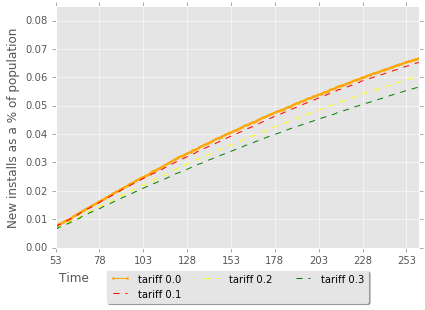

In [373]:
data_mode = 'bm_'
test_mode = 'inst'
column = ['N_installed_sum']

fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
axes = [axes_]

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = dfs_w[0].index.values[N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY] + 1

lines = []

#markers = ["o-", "^-", "^-", "^-", "*-"]
markers = ["o-", "--", "--", "--", "*-"]
markerfacecolors = colors_
colors_l = ['r', 'r', 'r']
labels = ['tariff ' + str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=True)]

for i in range(N_TESTS) :
    pi, = axes[0].plot(ind, dfs_w[i][column][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000, markers[i], label=labels[i])
    
#    axes[0].fill_between(ind, 
#                  np.asarray((dfs_w[i][column][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000\
#                        -2*dfs_w_std[i][column][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000).values).reshape(N_TICKS_DISPLAY,), 
#                  np.asarray((dfs_w[i][column][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000\
#                        +2*dfs_w_std[i][column][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000).values).reshape(N_TICKS_DISPLAY), 
#                  color=markerfacecolors[i], 
#                  alpha=0.2)
    
    pi.set_markerfacecolor(markerfacecolors[i])
    pi.set_color(markerfacecolors[i])
    pi.set_markeredgecolor(markerfacecolors[i])
    pi.set_markersize(2)
    lines.append(pi)
    

axes[0].set_xlabel("Time")
axes[0].xaxis.set_label_coords(0.05, -0.1)
axes[0].set_ylabel("New installs as a % of population")
    
# Shrink current axis's height by 10% on the bottom
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='lower center', bbox_to_anchor=(0.5, -0.25),\
          fancybox=True, shadow=True, fontsize='10', ncol = 3)

axes[0].set_xlim([N_TICKS_BURN + 1,N_TICKS_BURN + N_TICKS_DISPLAY])
axes[0].set_ylim([0.00, 0.085])
start = N_TICKS_BURN + 1
end = N_TICKS_BURN + N_TICKS_DISPLAY
axes[0].xaxis.set_ticks(np.arange(start, end, 25))


plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Jun18' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

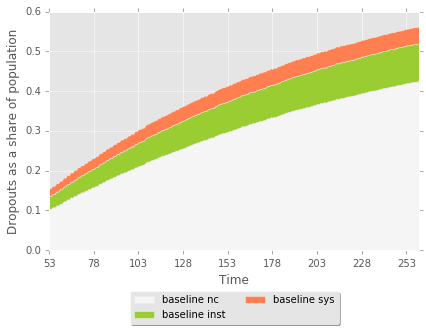

In [30]:
#number of dropouts as stacked bars
data_mode = 'bm_'
test_mode = 'drops'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#reverse order of simulations
#df_logs = dfs_logs[-1]

#if ncols = 1  - transform into list
axes = [axes_]

#baseline
df_logs = dfs_logs[-1]

#axes_0_tw = axes[0].twinx()

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = df_logs.index.values[N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY] + 1

lines = []
i = 0

markers = ["ro", "r^", "r*"]
markerfacecolors = colors_
colors_l = ['r', 'r', 'r']
labels_raw = ["nc", "inst", "sys"]
labels = ['baseline ' + x for x in labels_raw]
data_ = []
markers_ = []
labels_ = []
colors_graph_ = []
data_columns = ['EParamTypes::HOStateDroppedOutNCDecStage',\
                   'EParamTypes::HOStateDroppedOutSEIStage',\
                   'EParamTypes::HOStateDroppedOutDesignStage',\
                   'EParamTypes::HONumberActiveAgents']

for column in data_columns[0:3]:
    data_.append(df_logs[column][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000)
    markers_.append(markers[i])
    labels_.append(labels[i])
    colors_graph_.append(colors_[i])

    i = i + 1
    
pi = axes[0].stackplot(ind, data_, colors=tuple(['whitesmoke', 'yellowgreen', 'coral']), labels=tuple(labels_))
    


for pi_ in pi:
    lines.append(pi_)

    
markers = ["go", "g^", "g*"]
colors_l = ['g', 'g', 'g']
labels = ['high ef ' + x for x in labels_raw]

   

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Dropouts as a share of population")


#axes[0].set_autoscaley_on(False)
axes[0].set_xlim([N_TICKS_BURN +1,N_TICKS_BURN +N_TICKS_DISPLAY])
#axes_0_tw.set_ylim([0.0, 5.0])
start = N_TICKS_BURN +1
end = N_TICKS_BURN +N_TICKS_DISPLAY
axes[0].xaxis.set_ticks(np.arange(start, end, 25))




# Shrink current axis's height by 10% on the bottom
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=True, shadow=True, fontsize='10', ncol = 2)




plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Mar18' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [375]:
dfs_logs[-1]['SumEParamTypes::HOStateDroppedOutTickNCDecStage'] = dfs_logs[-1]['EParamTypes::HOStateDroppedOutTickNCDecStage'].cumsum()
dfs_logs[-1]['SumEParamTypes::HOStateDroppedOutTickSEIStage'] = dfs_logs[-1]['EParamTypes::HOStateDroppedOutTickSEIStage'].cumsum()
dfs_logs[-1]['SumEParamTypes::HOStateDroppedOutTickDesignStage'] = dfs_logs[-1]['EParamTypes::HOStateDroppedOutTickDesignStage'].cumsum()

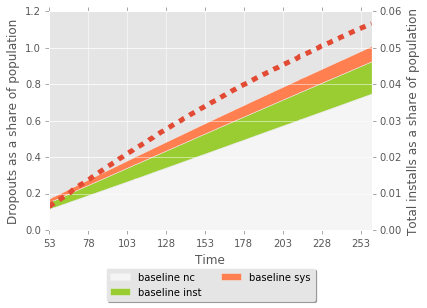

In [376]:
#number of dropouts as stacked bars
data_mode = 'bm_'
test_mode = 'drops'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#reverse order of simulations
#df_logs = dfs_logs[-1]

#if ncols = 1  - transform into list
par1 = axes_.twinx()
axes = [axes_, par1]

#baseline
df_logs = dfs_logs[-1]

#axes_0_tw = axes[0].twinx()

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = df_logs.index.values[N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY] + 1

lines = []
i = 0

markers = ["ro", "r^", "r*"]
markerfacecolors = colors_
colors_l = ['r', 'r', 'r']
labels_raw = ["nc", "inst", "sys"]
labels = ['baseline ' + x for x in labels_raw]
data_ = []
markers_ = []
labels_ = []
colors_graph_ = []
data_columns = ['SumEParamTypes::HOStateDroppedOutTickNCDecStage',\
                   'SumEParamTypes::HOStateDroppedOutTickSEIStage',\
                   'SumEParamTypes::HOStateDroppedOutTickDesignStage',\
                   'EParamTypes::HONumberActiveAgents']

for column in data_columns[0:3]:
    data_.append(df_logs[column][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000)
    markers_.append(markers[i])
    labels_.append(labels[i])
    colors_graph_.append(colors_[i])

    i = i + 1
    
pi = axes[0].stackplot(ind, data_, colors=tuple(['whitesmoke', 'yellowgreen', 'coral']), labels=tuple(labels_))
    


for pi_ in pi:
    lines.append(pi_)

    
markers = ["go", "g^", "g*"]
colors_l = ['g', 'g', 'g']
labels = ['high ef ' + x for x in labels_raw]

   

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Dropouts as a share of population")


#axes[0].set_autoscaley_on(False)
axes[0].set_xlim([N_TICKS_BURN +1,N_TICKS_BURN +N_TICKS_DISPLAY])
#axes_0_tw.set_ylim([0.0, 5.0])
start = N_TICKS_BURN +1
end = N_TICKS_BURN +N_TICKS_DISPLAY
axes[0].xaxis.set_ticks(np.arange(start, end, 25))




# Shrink current axis's height by 10% on the bottom
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=True, shadow=True, fontsize='10', ncol = 2)


markers = ["o-", "--", "--", "--", "*-"]
markerfacecolors = colors_
colors_l = ['r', 'r', 'r']
labels = ['tariff ' + str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=True)]

#number of installs
pi, = axes[1].plot(ind, dfs_w[-1]['N_installed_sum'][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000, markers[1], linewidth=5)

axes[1].set_ylabel("Total installs as a share of population")


plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Jun18' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [377]:
print(len(dfs_logs))
print(N_TESTS)

4
4


In [378]:
dfs_w[0]['N_installed_sum'].values[N_TICKS_BURN +N_TICKS_DISPLAY]

670.44444444444446

In [379]:
data_columns = ['EParamTypes::HOStateDroppedOutNCDecStage',\
                   'EParamTypes::HOStateDroppedOutSEIStage',\
                   'EParamTypes::HOStateDroppedOutDesignStage']

data_drops = []
column_i = 0
for column in data_columns[0:3]:
    data_drops.append([])

    for i in range(N_TESTS):
        #print(dfs_logs[i][column][N_TICKS_BURN+N_TICKS_DISPLAY-1:N_TICKS_BURN +N_TICKS_DISPLAY].values[-1])
        data_drops[column_i].append(dfs_logs[i][column][N_TICKS_BURN+N_TICKS_DISPLAY-1:N_TICKS_BURN +N_TICKS_DISPLAY].values[-1]\
                                    /dfs_w[i]['N_installed_sum'].values[N_TICKS_BURN +N_TICKS_DISPLAY])
    column_i = column_i + 1     


In [380]:
print(data_drops)

[[6.0200530328140536, 6.2890826435065819, 6.9570081479447037, 7.5517666634041296], [1.4284719920450779, 1.4694327588546614, 1.5810674723061429, 1.6940589214055009], [0.72331786542923437, 0.72703216175871899, 0.74347706673990666, 0.76061466183811299]]


In [381]:
data_drops_acc = [[data_drops[0][i] for i in range(N_TESTS)]]
print(data_drops_acc)
        

[[6.0200530328140536, 6.2890826435065819, 6.9570081479447037, 7.5517666634041296]]


In [382]:
for i in range(1, len(data_drops), 1):
    data_drops_acc.append([])
    #print(data_drops_acc)
    for j in range(0, N_TESTS, 1):
        data_drops_acc[i].append(data_drops_acc[i-1][j] + data_drops[i][j])
        
print(data_drops_acc)

[[6.0200530328140536, 6.2890826435065819, 6.9570081479447037, 7.5517666634041296], [7.4485250248591317, 7.758515402361243, 8.5380756202508472, 9.24582558480963], [8.1718428902883655, 8.4855475641199618, 9.2815526869907536, 10.006440246647744]]


In [383]:
for i in range(len(data_drops[0])):
    print(data_drops[1][i]/data_drops[0][i])

0.237285615967
0.233648187208
0.227262558658
0.224326173849


In [384]:
for i in range(len(data_drops[0])):
    print(data_drops[2][i]/data_drops[0][i])

0.120151410874
0.11560225918
0.106867356043
0.100720095805


In [385]:
len(data_columns)

3

[7.4485250248591317, 7.758515402361243, 8.5380756202508472, 9.24582558480963]
[6.0200530328140536, 6.2890826435065819, 6.9570081479447037, 7.5517666634041296]
[8.1718428902883655, 8.4855475641199618, 9.2815526869907536, 10.006440246647744]
[7.4485250248591317, 7.758515402361243, 8.5380756202508472, 9.24582558480963]


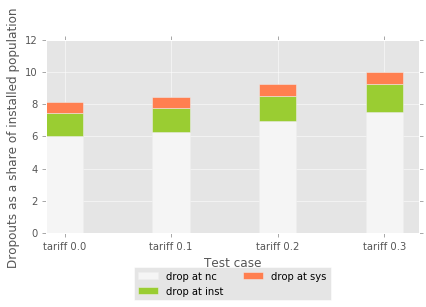

In [386]:
#number of dropouts as stacked bars
data_mode = 'bm_'
test_mode = 'drops_all_tariff'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
axes = [axes_]

ind = np.arange(len(dfs_logs))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


colors_drops = tuple(['whitesmoke', 'yellowgreen', 'coral'])

#N_TESTS = len(dfs_logs)
labels_raw = ["nc", "inst", "sys"]
labels_hist = ['drop at ' + x for x in labels_raw]

p1 = axes[0].bar(ind[0:N_TESTS], data_drops_acc[0][0:N_TESTS],\
                 width, color=colors_drops[0], label = labels_hist[0])
lines = [p1]



for bin_ in range(1, len(data_columns), 1):
    print(data_drops_acc[bin_][0:N_TESTS])
    print(data_drops_acc[bin_ - 1][0:N_TESTS])
    p2 = axes[0].bar(ind[0:N_TESTS], \
                     data_drops[bin_][0:N_TESTS], \
                     width, color=colors_drops[bin_], \
                  bottom=data_drops_acc[bin_ - 1][0:N_TESTS], label = labels_hist[bin_])
    lines.append(p2)
    
axes[0].set_xlabel("Test case")
axes[0].set_ylabel("Dropouts as a share of installed population")
#axes[0].set_title('Accumulated % installations \n by the level \n of income', fontsize=10)


axes[0].set_xticks(ind[0:N_TESTS] + width / 2)
axes[0].set_xticklabels(ind[0:N_TESTS])
x_labels = ['1', '2', '3', '4']
labels = ['tariff ' + str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=True)]
x_labels = labels
axes[0].set_xticklabels(x_labels)

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=False, shadow=False, fontsize='10', ncol = 2)



plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Jun18' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [52]:
print(ind)

[0 1 2 3]


In [ ]:
#penetration by income group in time?
#penetration by el bill in time? 



In [121]:
#location x, location y 


# for each line - place into location
# average over locations
#
#

N_TILES = 10
N_SEEDS = 8

test_mode = 'BaseVer02'
data_mode = 'CA'

#names of columns in a file
names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Mart_type']

raw_data_per_tick = []
raw_data_dfs_per_tick = []
tick_bins = []
for i in range(4):
    #to store final results
    raw_data_per_tick.append(np.zeros((N_TILES, N_TILES)))
    #to store intermediate results
    raw_data_dfs_per_tick.append(np.zeros((N_SEEDS, N_TILES, N_TILES)))
    #tick edges
    tick_bins.append(N_TICKS/4 *(i))


#here only baseline scenario is analyzed    
params_versions = [str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=False)]
    
#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('..\\..\\ABMIRISLab\\Saves\\Jan-11-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                 '\\tariff' + str(0.3) + '\\*[_pr].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top x files, assume only one type of a simulation run in a folder 
i_run = 0

for file in files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]:
    print(file)
    df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
    dfs_.append(df_)

    
raw_data_dfs = np.zeros((len(dfs_), N_TILES, N_TILES))

indexes = [0.0, 0.0, 0.0, 0.0]

k = 0
for df_ in dfs_:
    
    
    
    for i in range(N_TILES):
        for j in range(N_TILES):
            index = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j)].index 
                             
            indexes[0] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[0])].index
            
            indexes[1] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[1])].index
            
            indexes[2] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[2])].index
                             
            raw_data_dfs_per_tick[0][k, i, j] = df_.iloc[indexes[0]].shape[0]
            raw_data_dfs_per_tick[1][k, i, j] = df_.iloc[indexes[1]].shape[0]
            raw_data_dfs_per_tick[2][k, i, j] = df_.iloc[indexes[2]].shape[0]
            raw_data_dfs_per_tick[-1][k, i, j] = df_.iloc[index].shape[0]
            
    k = k + 1
    
    raw_data_per_tick[0] = np.mean(raw_data_dfs_per_tick[0], axis = 0)
    raw_data_per_tick[1] = np.mean(raw_data_dfs_per_tick[1], axis = 0)
    raw_data_per_tick[2] = np.mean(raw_data_dfs_per_tick[2], axis = 0)
    raw_data_per_tick[-1] = np.mean(raw_data_dfs_per_tick[-1], axis = 0)
    
    
#create df from them    
dfs_inst = dfs_

#blank first step
raw_data_per_tick[0] = np.zeros((N_TILES, N_TILES)) + 0.01

..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\37ed7bcf-e806-4fe2-b2bd-2b652ec7bcfd_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\29656eab-e4f9-4d65-92c2-d4bad48df315_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\5ca7a082-1cb0-448c-8278-36425f94ad49_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\c7b012ba-3ad5-40cc-81b1-2d92ba81cae8_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\20cf97d0-c313-4815-b0e7-8a952ec0ca19_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\1c784f8d-59fd-42ee-8b26-6c2e8c0d8558_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\3aab8956-253b-4ccb-8a0d-9ba92eee7158_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\f3cbc1de-38ce-4ac5-b4f0-7f193f542927_pr.csv


In [122]:
dfs_inst[-1].head(5)

,Tick,Location_x,Location_y,Uid,Price_per_watt,DC_size,Mart_type
0,37,9,2,43,2.8,2749.75,0
1,55,8,1,51,2.8,1820.13,0
2,45,4,5,55,2.8,3920.07,0
3,54,6,7,44,2.8,7000.12,0
4,55,8,2,40,2.8,4674.57,0


In [102]:
#define min and max installs
max_installs = np.amax(raw_data_per_tick[3])
min_installs = 0 

In [103]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [104]:
cmap = cm.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.2, 0.8)

In [105]:
raw_data_per_tick_norm = [0.0, 0.0, 0.0, 0.0]
for i in range(4):
    raw_data_per_tick_norm[i] = raw_data_per_tick[i] / max_installs

C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\w

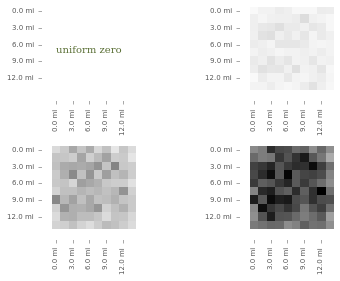

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.subplots_adjust(bottom=0.5)


for i in range(4):
    lines = []

#    cmap_custom = cm.get_cmap('YlGn')
    cmap_custom = cm.get_cmap('Greys')
    #cmap_custom = new_cmap

    #image = np.random.uniform(size=(10, 10))
    axes[i/2, i%2].imshow(raw_data_per_tick[i], cmap=cmap_custom, interpolation='nearest', vmin=0, vmax=max_installs)

    #ax.set_title('Number of installations \n in a neighborhood')

    # Move left and bottom spines outward by 10 points
    axes[i/2, i%2].spines['left'].set_position(('outward', 10))
    axes[i/2, i%2].spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    axes[i/2, i%2].spines['right'].set_visible(False)
    axes[i/2, i%2].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[i/2, i%2].yaxis.set_ticks_position('left')
    axes[i/2, i%2].xaxis.set_ticks_position('bottom')
    
    for tick in axes[i/2, i%2].get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize('x-small')
        
    for tick in axes[i/2, i%2].get_yticklabels():
        tick.set_fontsize('x-small')

    labels_ = ['mi']
    xs = range(10)

    from matplotlib.ticker import FuncFormatter, MaxNLocator
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in xs:
            return str(tick_val * 1.5) + ' ' + labels_[0]
        else:
            return ''


    axes[i/2, i%2].xaxis.set_major_formatter(FuncFormatter(format_fn))
    axes[i/2, i%2].yaxis.set_major_formatter(FuncFormatter(format_fn))

    axes[i/2, i%2].grid(False)




#    handles, labels = ax.get_legend_handles_labels()

    # Put a legend below current axis
    #lgd = ax.legend(handles, ['test'], loc='lower center', bbox_to_anchor=(0.5, -0.25),\
    #          fancybox=True, shadow=True, fontsize='10', ncol = 2)

    
#add comment to the first plot
font = {'family': 'serif',
        'color':  'darkolivegreen',
        'weight': 'normal',
        'size': 10,
        }
axes[0,0].text(0.0, 5.0, 'uniform zero', fontdict=font)
    

plt.tight_layout()
data_mode = 'test'
plt.savefig('Simulation_results_spatial_' + data_mode + '_Mar14' + '.png', dpi=300)

plt.show()

In [21]:
#redo bubbles figure

In [123]:
dfs_agg_inst = []
for df_ in dfs_inst:

    df_['Count'] = 1
    grouped = df_.groupby('Uid', sort=False)
    df_agg = grouped.agg({'Price_per_watt' : np.median,\
             'DC_size' : np.median, \
            'Count' : np.sum})
    dfs_agg_inst.append(df_agg)
    
df_inst_all = pd.concat(dfs_agg_inst)
df_inst_mean = df_agg.groupby(level=0).mean()

In [124]:
df_inst_all.head(20)

,Count,DC_size,Price_per_watt
Uid,,,
54,28,4533.330,2.51430
57,24,5175.890,2.61782
55,77,4768.280,2.48746
40,55,4399.600,2.59964
52,26,5362.005,2.63676
42,33,5499.490,2.60233
56,16,5226.090,2.51463
48,43,4160.680,2.60184
53,16,4140.710,2.52148


In [107]:
df_inst_mean.head(20)

,Count,DC_size,Price_per_watt
Uid,,,
40,41,4399.600,2.595290
41,50,5200.380,2.593990
42,64,5520.950,2.502640
43,36,4760.080,2.593150
44,50,5040.090,2.601570
45,22,5348.420,2.461145
46,55,4501.090,2.600780
47,37,4238.470,2.479600
48,65,4680.760,2.592880


In [108]:
#sort by count?
df_inst_mean = df_inst_mean.sort_values('Count', ascending=False)

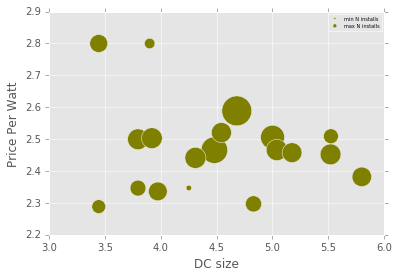

In [29]:
N = 19





x = df_inst_mean['DC_size']/1000
y = df_inst_mean['Price_per_watt']
norm = matplotlib.colors.Normalize(vmin=df_inst_mean['Count'].values[N-1], vmax=df_inst_mean['Count'].values[0])
cmap_custom = cm.get_cmap('Spectral')
area = norm(df_inst_mean['Count'])
color = []

for area_x in area:
#    color.append(cmap_custom(area_x/2))
    color.append('olive')
    

    
#color[1] = (0.0, 0.65, 0.75, 1.0)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('DC size')
ax.set_ylabel('Price Per Watt')

#ax.set_autoscaley_on(False)
#ax.set_xlim([0,0.2])
#ax.set_ylim([0,5])
    
#plt.xlabel('Price Per Watt')
#plt.ylabel('System Size AC')
#plt.title('Number of Installations Per Company')

ax.scatter(x, y, s=df_inst_mean['Count'] * 10,  c = color )
handles, labels = ax.get_legend_handles_labels()


#names are here
#df_agg.index.values[0:3]

#colors are here
#color[0:3]

artists = []
labels = []

#create custom artists
#for i in range(3):
#    artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[i]))
#    labels.append(df_agg_dm1.index.values[i])

artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[-1], label='min'))
labels.append('min N installs')
artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[0], label='max'))
labels.append('max N installs')
    

class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
#        print(orig_handle.__dict__)
        radius_ = width/10
        if ('max' in orig_handle._label):
            radius_ = width/5
    
        p = mpatches.Circle(xy=center, radius=radius_)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    

#Create legend from custom artist/label lists
ax.legend(artists,
          labels,
         handler_map={mpatches.Circle: HandlerEllipse()}, bbox_to_anchor=(0.9, 0.9),
           bbox_transform=plt.gcf().transFigure, fontsize=5
         )



#plt.scatter(x, y, s=df_agg_top['Count'],  c = color )
data_mode = 'test'
plt.savefig('Simulation_results_installers_' + data_mode + '_Mar18' + '.png', dpi=300)
plt.show()

In [125]:
#sort by count?
df_inst_all = df_inst_all.sort_values('Count', ascending=False)

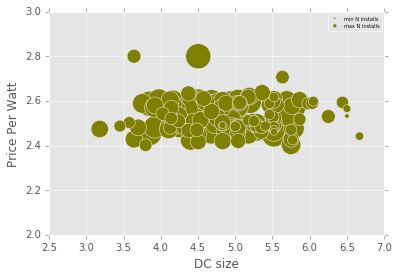

In [126]:
N = 19





x = df_inst_all['DC_size']/1000
y = df_inst_all['Price_per_watt']
norm = matplotlib.colors.Normalize(vmin=df_inst_all['Count'].values[N-1], vmax=df_inst_all['Count'].values[0])
cmap_custom = cm.get_cmap('Spectral')
area = norm(df_inst_all['Count'])
color = []

for area_x in area:
#    color.append(cmap_custom(area_x/2))
    color.append('olive')
    

    
#color[1] = (0.0, 0.65, 0.75, 1.0)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('DC size')
ax.set_ylabel('Price Per Watt')

#ax.set_autoscaley_on(False)
ax.set_xlim([2.5,7.0])
ax.set_ylim([2.0,3.0])
    
#plt.xlabel('Price Per Watt')
#plt.ylabel('System Size AC')
#plt.title('Number of Installations Per Company')

ax.scatter(x, y, s=df_inst_all['Count'] * 10,  c = color )
handles, labels = ax.get_legend_handles_labels()


#names are here
#df_agg.index.values[0:3]

#colors are here
#color[0:3]

artists = []
labels = []

#create custom artists
#for i in range(3):
#    artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[i]))
#    labels.append(df_agg_dm1.index.values[i])

artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[-1], label='min'))
labels.append('min N installs')
artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[0], label='max'))
labels.append('max N installs')
    

class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
#        print(orig_handle.__dict__)
        radius_ = width/10
        if ('max' in orig_handle._label):
            radius_ = width/5
    
        p = mpatches.Circle(xy=center, radius=radius_)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    

#Create legend from custom artist/label lists
ax.legend(artists,
          labels,
         handler_map={mpatches.Circle: HandlerEllipse()}, bbox_to_anchor=(0.9, 0.9),
           bbox_transform=plt.gcf().transFigure, fontsize=5
         )



#plt.scatter(x, y, s=df_agg_top['Count'],  c = color )
data_mode = 'test'
plt.savefig('Simulation_results_installers_' + data_mode + '_Apr18_2' + '.png', dpi=300)
plt.show()

# Testing random code

In [ ]:
#how to see what is inside an object
print(mpatches.Circle((0, 0), 5.0, facecolor=color[0]).__dict__)

In [38]:
#sticky prices
y_start = 0.2
y_target = 0.5
theta_learn = 0.99
y_prog_ = [y_start]
x_tick_ = []
for i in range(200):
    y_prog_.append(y_prog_[-1] * theta_learn + y_target * (1 - theta_learn))
    x_tick_.append(i)

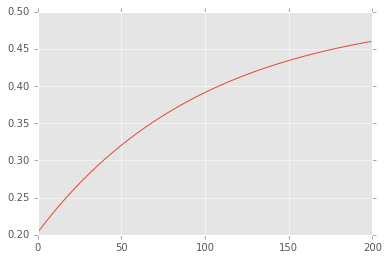

In [58]:
plt.plot(x_tick_, y_prog_[1:])

In [35]:
prices  = dfs_w[0]['P_av']

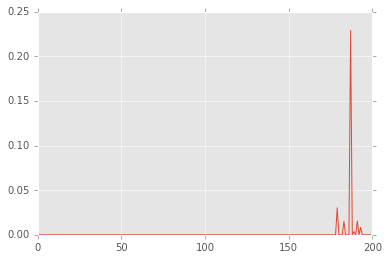

In [39]:
plt.plot(x_tick_, prices[0:200])

In [45]:
dfs_inst[0].head()

,Tick,Location_x,Location_y,Uid,Price_per_watt,DC_size
0,29,9,8,48,4.34654,5199.74
1,43,4,6,48,5.33618,4501.09
2,37,4,4,46,3.47883,9002.18
3,65,7,3,48,4.61828,5251.27
4,147,1,3,40,5.29697,4140.71


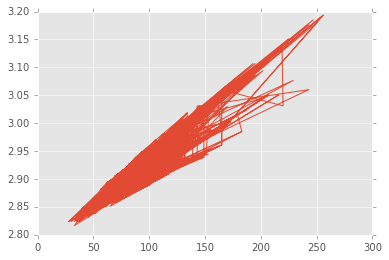

In [66]:
plt.plot(dfs_inst[0]['Tick'], dfs_inst[0]['Price_per_watt'])

In [20]:
test_mode = 'BaseModel'
test_version = 'BaseVer01'
test_loc = 'CA'
data_mode = 'Logs'
version = '_eff'
params_versions = [str(x) for x in np.linspace(1.0,1.5,1,endpoint=False)]
i_run = 0

In [33]:
files = glob.glob('..\\..\\ABMIRISLab\\Saves\\Oct-18-2017\\' + test_mode + '\\' + test_version + '\\'  +\
                          test_loc + '\\' + params_versions[i_run] + '\\' + data_mode +\
                         '\\*[_log].log')
files.sort(key=os.path.getmtime, reverse=True)
        #files_ = files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]    

In [34]:
len(files)

50

In [6]:
df_test = pd.DataFrame([[0,1],[0.1, 0.15], [0.9, 0.85], [200, 205]]).T

In [7]:
df_test.head()

,0,1,2,3
0,0.0,0.10,0.90,200.0
1,1.0,0.15,0.85,205.0


Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')


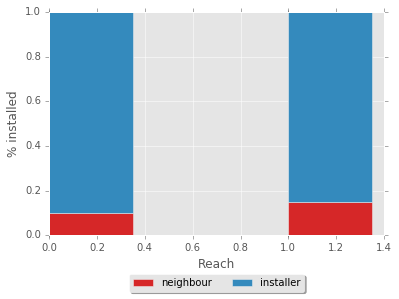

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Reach')
ax.set_ylabel('% installed')
lines = []
N = 2

ind = np.arange(N)
width = 0.35


p1 = plt.bar(ind, df_test[1], width, color='#d62728', label='neighbour')
p2 = plt.bar(ind, df_test[2], width,
             bottom=df_test[1], label='installer')

lines.append(p1)
lines.append(p2)


for tick in ax.get_xticklabels():
    print(tick)
    
ax.xaxis.set_ticks(ind, tuple([str(x) for x in ind]))

# Put a legend below current axis
lgd = ax.legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=True, shadow=True, fontsize='10', ncol = 2)


plt.show()

In [15]:
print(tuple([str(x) for x in ind]))

('0', '1')


In [83]:
dfs_w[i]['N_installed_sum'].ix[260]

634.625

In [84]:
dfs_w[3]['N_installed_sum'].ix[260]/dfs_w[0]['N_installed_sum'].ix[260]

0.84923180820530142

In [144]:
#location x, location y 


# for each line - place into location
# average over locations
#
#

N_TILES = 10
N_SEEDS = 8

test_mode = 'BaseVer02'
data_mode = 'CA'

#names of columns in a file
names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Mart_type']

raw_data_per_tick = []
raw_data_dfs_per_tick = []
tick_bins = []
for i in range(4):
    #to store final results
    raw_data_per_tick.append(np.zeros((N_TILES, N_TILES)))
    #to store intermediate results
    raw_data_dfs_per_tick.append(np.zeros((N_SEEDS, N_TILES, N_TILES)))
    #tick edges
    tick_bins.append(N_TICKS/4 *(i))


#here only baseline scenario is analyzed    
params_versions = [str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=False)]
    
#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('..\\..\\ABMIRISLab\\Saves\\Jan-11-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                 '\\tariff' + str(0.3) + '\\*[_pr].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top x files, assume only one type of a simulation run in a folder 
i_run = 0

for file in files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]:
    print(file)
    df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
    dfs_.append(df_)

    
raw_data_dfs = np.zeros((len(dfs_), N_TILES, N_TILES))

indexes = [0.0, 0.0, 0.0, 0.0]

k = 0
for df_ in dfs_:
    
    
    
    for i in range(N_TILES):
        for j in range(N_TILES):
            index = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j)].index 
                             
            indexes[0] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[0])].index
            
            indexes[1] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[1])].index
            
            indexes[2] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[2])].index
                             
            raw_data_dfs_per_tick[0][k, i, j] = df_.iloc[indexes[0]].shape[0]
            raw_data_dfs_per_tick[1][k, i, j] = df_.iloc[indexes[1]].shape[0]
            raw_data_dfs_per_tick[2][k, i, j] = df_.iloc[indexes[2]].shape[0]
            raw_data_dfs_per_tick[-1][k, i, j] = df_.iloc[index].shape[0]
            
    k = k + 1
    
    raw_data_per_tick[0] = np.mean(raw_data_dfs_per_tick[0], axis = 0)
    raw_data_per_tick[1] = np.mean(raw_data_dfs_per_tick[1], axis = 0)
    raw_data_per_tick[2] = np.mean(raw_data_dfs_per_tick[2], axis = 0)
    raw_data_per_tick[-1] = np.mean(raw_data_dfs_per_tick[-1], axis = 0)
    
    
#create df from them    
dfs_inst = dfs_

#blank first step
raw_data_per_tick[0] = np.zeros((N_TILES, N_TILES)) + 0.01

..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\e134031c-60bc-4586-8cd0-9abab6219a65_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\9a8d1051-c20f-426c-9654-8ac12fc86263_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\827986a4-67ca-4b04-8ea3-adff0b784dc0_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\442f886c-20c5-479e-8ecd-9956e011e9fd_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\d711f29d-3bd5-486b-acb1-e9422e8286f0_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\42561ea7-2046-407c-81f3-06b70777e17a_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\e7f3e9ee-edc2-4891-b0ad-8b81e8e933e6_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\dfc53c5d-88f6-4a89-bdac-39da9c390e58_pr.csv


In [145]:
dfs_inst[0].head() 

,Tick,Location_x,Location_y,Uid,Price_per_watt,DC_size,Origin,Mart_type
0,36,7,2,45,2.80000,7426.55,Import,0
1,80,0,8,44,2.59459,3000.73,Domestic,0
2,34,9,8,57,2.80000,6440.73,Domestic,0
3,80,5,7,59,2.59194,7682.22,Import,0
4,32,3,7,58,2.80000,9076.90,Import,0


In [ ]:
dfs_agg_inst = []
for df_ in dfs_inst:

    df_['Count'] = 1
    grouped = df_.groupby('Uid', sort=False)
    df_agg = grouped.agg({'Price_per_watt' : np.median,\
             'DC_size' : np.median, \
            'Count' : np.sum})
    dfs_agg_inst.append(df_agg)
    
df_inst_all = pd.concat(dfs_agg_inst)
df_inst_mean = df_agg.groupby(level=0).mean()

In [7]:
N_SEEDS = 150

In [30]:
def collect_data_for_simulation_runs_from_inst(N_TESTS, dfs_inst, dfs_inst_std):

    test_mode = 'BaseVer02'
    data_mode = 'CA'
    #here think how to change it
    params_versions = [str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=True)]
    params_versions = ['0.0', '0.1', '0.2', '0.3']

    #names of columns in a file
    names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Efficency','EquipmentType', 'InteractionType','Mart_type']
    #names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Mart_type']


    for i_run in range(N_TESTS): 
        #read few files
        #save into database
        dfs_ = []
        #read last simulation result
        files = glob.glob('..\\..\\ABMIRISLab\\Saves\\May-14-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                 '\\tariff' + params_versions[i_run] + '\\*[_pr].csv')
        files = glob.glob('../../ABMIRISLab/Saves/May-14-2018/BaseModel/'+ test_mode + '/' + data_mode + \
                 '/tariff'+ params_versions[i_run] + '/*[_pr].csv')
        files.sort(key=os.path.getmtime, reverse=True)

        #take top x files 
        for file in files[0 * N_SEEDS : 1 * N_SEEDS]:
            #print(file)
            df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
            df_['Total_price'] = df_['Price_per_watt'] * df_['DC_size']
            dfs_.append(df_)


        #create df from them    
        df_concat = pd.concat(dfs_)
        
        
        df_inst_mean = df_concat.groupby(level=0).mean()
        df_inst_std = df_concat.groupby(level=0).std()
        
        dfs_inst.append(dfs_)


In [31]:
dfs_inst = []
dfs_inst_std = []
collect_data_for_simulation_runs_from_inst(N_TESTS, dfs_inst, dfs_inst_std)

In [32]:
print(len(dfs_inst))

4


In [33]:
dfs_agg_inst = []
df_inst_all = []
df_inst_mean = []

for i in range(len(dfs_inst)):
    for df_ in dfs_inst[i]:
#        print(df_)
        df_['Count'] = 1
        grouped = df_.groupby('Origin', sort=False)
        df_agg = grouped.agg({'Total_price' : np.sum,\
                 'DC_size' : np.sum, \
                'Count' : np.sum,
                             'Price_per_watt': np.average})
        dfs_agg_inst.append(df_agg)

    df_inst_all.append(pd.concat(dfs_agg_inst))
    df_inst_mean.append(df_agg.groupby(level=0).mean())

In [34]:
print(df_inst_mean)

[           Total_price      DC_size  Count  Price_per_watt
Origin                                                    
Domestic  5.668872e+06  2263885.703    393        2.507215
Import    4.014840e+06  1596854.124    307        2.509379,            Total_price      DC_size  Count  Price_per_watt
Origin                                                    
Domestic  4.965705e+06  2005829.653    392        2.475425
Import    2.812090e+06  1099137.742    240        2.565865,            Total_price      DC_size  Count  Price_per_watt
Origin                                                    
Domestic  3.607707e+06  1463642.680    282        2.461817
Import    4.145076e+06  1603753.703    335        2.584736,            Total_price      DC_size  Count  Price_per_watt
Origin                                                    
Domestic  3.941502e+06  1549238.974    265        2.546724
Import    6.265401e+06  2437209.794    440        2.569170]


In [133]:
for i in range(len(df_inst_mean)):
    print(np.sum(df_inst_mean[i]['DC_size']))

4174622.153
3736633.135
3305849.795
3263779.878


In [134]:
for i in range(len(df_inst_mean)):
    print(np.sum(df_inst_mean[i]['Total_price']))

10473399.3422
9298813.64591
8317839.39549
8378988.06399


In [135]:
for i in range(len(df_inst_mean)):
    print(np.sum(df_inst_mean[i]['Count']))

825
727
661
634


In [136]:
df_inst_mean[i].at['Domestic', 'Count']

439

In [137]:
data_columns = ['Domestic',\
                   'Foreign']
data_installs_origin = []
for i in range(N_TESTS):
    data_installs_origin.append([df_inst_mean[i].at['Domestic', 'Count'], \
                      df_inst_mean[i].at['Import', 'Count'],\
                                df_inst_mean[i].at['Domestic', 'Total_price'],\
                                df_inst_mean[i].at['Import', 'Total_price']])

In [138]:
print(data_installs_origin)

[[509, 316, 6415785.6950671328, 4057613.6471693125], [264, 463, 3637317.3965997305, 5661496.249306879], [241, 420, 3170599.935698322, 5147239.4597908203], [439, 195, 5696325.7849850142, 2682662.2790014814]]


In [139]:
data_installs_plot = np.array(data_installs_origin)


In [140]:
print(data_installs_plot.T)

[[  5.09000000e+02   2.64000000e+02   2.41000000e+02   4.39000000e+02]
 [  3.16000000e+02   4.63000000e+02   4.20000000e+02   1.95000000e+02]
 [  6.41578570e+06   3.63731740e+06   3.17059994e+06   5.69632578e+06]
 [  4.05761365e+06   5.66149625e+06   5.14723946e+06   2.68266228e+06]]


In [141]:
data_installs_plot.T[0][0:N_TESTS]

array([ 509.,  264.,  241.,  439.])

In [142]:
data_installs_plot.T[1][0:N_TESTS]

array([ 316.,  463.,  420.,  195.])

[ 316.  463.  420.  195.]
[ 509.  264.  241.  439.]


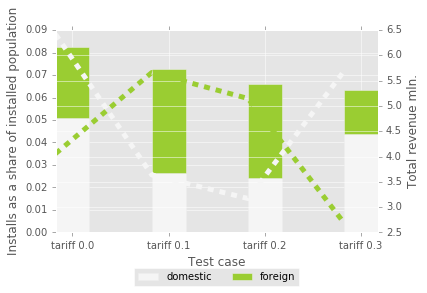

In [143]:
#number of dropouts as stacked bars
data_mode = 'bm_'
test_mode = 'installs_origin'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
par1 = axes_.twinx()
axes = [axes_, par1]

ind = np.arange(len(dfs_inst))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


colors_drops = tuple(['whitesmoke', 'yellowgreen', 'coral'])

#N_TESTS = len(dfs_logs)
labels_raw = ['domestic', 'foreign']
labels_hist = ['' + x for x in labels_raw]

p1 = axes[0].bar(ind[0:N_TESTS], data_installs_plot.T[0][0:N_TESTS]/10000,\
                 width, color=colors_drops[0], label = labels_hist[0])
lines = [p1]



for bin_ in range(1, 2, 1):
    print(data_installs_plot.T[bin_][0:N_TESTS])
    print(data_installs_plot.T[bin_ - 1][0:N_TESTS])
    p2 = axes[0].bar(ind[0:N_TESTS], \
                     data_installs_plot.T[bin_][0:N_TESTS]/10000, \
                     width, color=colors_drops[bin_], \
                  bottom=data_installs_plot.T[bin_ - 1][0:N_TESTS]/10000, label = labels_hist[bin_])
    lines.append(p2)
    
axes[0].set_xlabel("Test case")
axes[0].set_ylabel("Installs as a share of installed population")
#axes[0].set_title('Accumulated % installations \n by the level \n of income', fontsize=10)


axes[0].set_xticks(ind[0:N_TESTS] + width / 2)
axes[0].set_xticklabels(ind[0:N_TESTS])
x_labels = ['1', '2', '3', '4']
labels = ['tariff ' + str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=True)]
x_labels = labels
axes[0].set_xticklabels(x_labels)

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=False, shadow=False, fontsize='10', ncol = 2)


markers = ["o-", "--", "--", "--", "*-"]
markerfacecolors = colors_drops
colors_l = ['r', 'r', 'r']


#number of installs
pi, = axes[1].plot(ind, data_installs_plot.T[2][0:N_TESTS]/1000000, markers[1], linewidth=5,color = markerfacecolors[0])
pi, = axes[1].plot(ind, data_installs_plot.T[3][0:N_TESTS]/1000000, markers[1], linewidth=5,color = markerfacecolors[1])

axes[1].set_ylabel("Total revenue mln.")


plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Jun27' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
df_inst_all

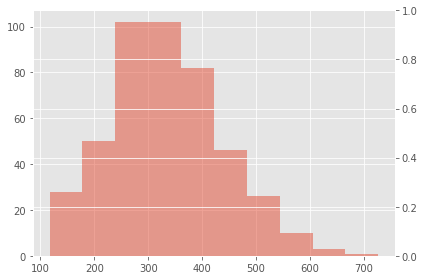

In [58]:
#number of dropouts as stacked bars
data_mode = 'bm_'
test_mode = 'installs_origin_v2'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

ind = np.arange(len(dfs_inst))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


#if ncols = 1  - transform into list
par1 = axes_.twinx()
axes = [axes_, par1]

ind = [1.0] * len (df_inst_all[-1].at['Domestic', 'Count'])

#p1 = axes[0].hist(df_inst_all[-1].at['Domestic', 'Count'], alpha = 0.5)
#p2 = axes[0].hist(df_inst_all[-1].at['Import', 'Count'], alpha = 0.5)

p5 = axes[0].hist(df_inst_all[2].at['Import', 'Count'], alpha = 0.5)
#p7 = axes[0].hist(df_inst_all[1].at['Import', 'Count'], alpha = 0.5)


#p3 = axes[1].hist(df_inst_all[0].at['Domestic', 'Count'], color = 'g', alpha = 0.5)
#p4 = axes[1].hist(df_inst_all[0].at['Import', 'Count'], color = 'b', alpha = 0.5)


plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Jul08' + '.png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
ind = [1.0] * len (df_inst_all[-1].at['Domestic', 'Count'])

In [53]:
print(len(ind))

600
